In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import statsmodels.api as sm

In [2]:
import matplotlib
import statsmodels

versions = {
    "yfinance": yf.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "statsmodels": statsmodels.__version__,
}
expected = {
    "yfinance": "0.1.69",
    "pandas": "1.3.5",
    "matplotlib": "3.5.0",
    "statsmodels": "0.13.0",
}

for lib in versions.keys():
    print(lib, "found:", versions[lib], "expected:", expected[lib])

yfinance found: 0.1.69 expected: 0.1.69
pandas found: 1.3.5 expected: 1.3.5
matplotlib found: 3.5.0 expected: 3.5.0
statsmodels found: 0.13.0 expected: 0.13.0


If there are any issues with the code try to update modules to match expected versions.

# Introduction

We will implement volume forecasting model based on a book *Algorithmic Trading Methods* (2021) by Robert Kissel.

We will be using very limited set of data from Yahoo! Finance for simplicity. 

Model consists of three components:
  - aggregation component
  - day of the week component
  - autoregressive error component
  
so we will see how each component affects model performance.


# Getting data



We will use data for **FAANG** stocks:
  - **F**acebook (Meta)
  - **A**pple
  - **A**mazon
  - **N**etflix
  - **G**oogle (Alphabet)

We will download them from Yahoo! Finance API using yfinance package.

In [3]:
faang_tickers = ["FB", "AAPL", "AMZN", "NFLX", "GOOG"]
try:
    faang = yf.Tickers(faang_tickers)
    faang_data = faang.history(start="2017-01-01", end="2021-12-31")
except Exception:
    faang_data = pd.read_csv(
        "data/faang.csv", header=[0, 1], index_col=0, parse_dates=[0]
    )

faang_data

[*********************100%***********************]  5 of 5 completed


Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Date                                                                       
2017-01-03   27.332470   753.669983  116.860001   786.140015  127.489998   
2017-01-04   27.301878   757.179993  118.690002   786.900024  129.410004   
2017-01-05   27.440720   780.450012  120.669998   794.020020  131.809998   
2017-01-06   27.746635   795.989990  123.410004   806.150024  131.070007   
2017-01-09   28.000784   796.919983  124.900002   806.650024  130.949997   
...                ...          ...         ...          ...         ...   
2021-12-23  176.279999  3421.370117  335.239990  2942.850098  614.090027   
2021-12-27  180.330002  3393.389893  346.179993  2961.280029  613.119995   
2021-12-28  179.289993  3413.219971  346.220001  2928.959961  610.710022   
2021-12-29  179.380005  3384.020020  342.940002  2930.090088  610.539978   
2021-12-30  178.199997  3372.889893  344.359985  2920.050049  612.090027   

           Dividends                    ... Stock Splits                    \
                AAPL AMZN FB GOOG NFLX  ...         AAPL AMZN FB GOOG NFLX   
Date                                    ...                                  
2017-01-03       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2017-01-04       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2017-01-05       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2017-01-06       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2017-01-09       0.0    0  0    0    0  ...          0.0    0  0    0    0   
...              ...  ... ..  ...  ...  ...          ...  ... ..  ...  ...   
2021-12-23       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2021-12-27       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2021-12-28       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2021-12-29       0.0    0  0    0    0  ...          0.0    0  0    0    0   
2021-12-30       0.0    0  0    0    0  ...          0.0    0  0    0    0   

               Volume                                        
                 AAPL     AMZN        FB     GOOG      NFLX  
Date                                                         
2017-01-03  115127600  3521100  20663900  1657300   9437900  
2017-01-04   84472400  2510500  19630900  1073000   7843600  
2017-01-05   88774400  5830100  19492200  1335200  10185500  
2017-01-06  127007600  5986200  28545300  1640200  10657900  
2017-01-09  134247600  3446100  22880400  1274600   5771800  
...               ...      ...       ...      ...       ...  
2021-12-23   68356600  1839400  13987700   690900   1621100  
2021-12-27   74919600  2934400  17795000   662800   2061500  
2021-12-28   79144300  2731900  16637600   931200   1882800  
2021-12-29   62348900  1787700  10747000   851100   1287200  
2021-12-30   59773000  1879200  10593300   648900   1625100  

[1258 rows x 35 columns]

We are only going to use only volume data, however, you could also try to use both price and volume data to predict volumes.
Let's have a brief look at our data.

We can immediately see that there are quite large differences between stock's trading volumes.
Apple seems to have the largest trading volume, while Google seems to have the smallest.

In [4]:
faang_data.loc[:, "Volume"]

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2017-01-03,115127600,3521100,20663900,1657300,9437900
2017-01-04,84472400,2510500,19630900,1073000,7843600
2017-01-05,88774400,5830100,19492200,1335200,10185500
2017-01-06,127007600,5986200,28545300,1640200,10657900
2017-01-09,134247600,3446100,22880400,1274600,5771800
...,...,...,...,...,...
2021-12-23,68356600,1839400,13987700,690900,1621100
2021-12-27,74919600,2934400,17795000,662800,2061500
2021-12-28,79144300,2731900,16637600,931200,1882800


<AxesSubplot:xlabel='Date'>

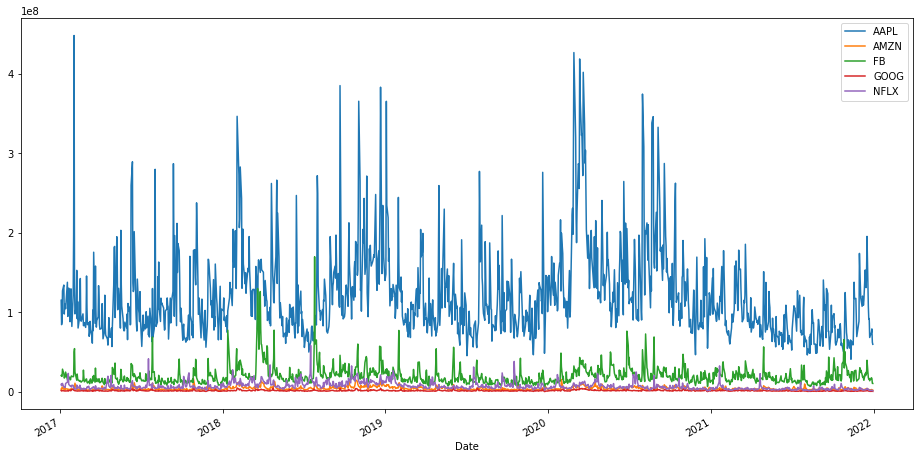

In [5]:
faang_data.loc[:, "Volume"].plot(figsize=(16, 8))

We can also see that there are periods where multiple stocks experience increased volumes.

But sometimes these "shocks" affect only individual stocks.

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

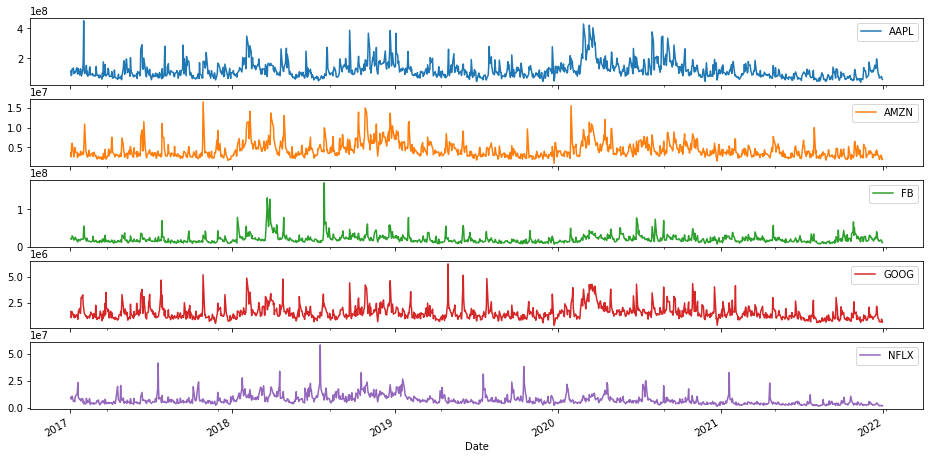

In [6]:
faang_data.loc[:, "Volume"].plot(subplots=True, figsize=(16, 8))

We will work with data in a "long" format

In [7]:
faang_volume = faang_data.loc[:, "Volume"].melt(
    var_name="symbol", value_name="volume", ignore_index=False
)
faang_volume.index.name = faang_volume.index.name.lower()
faang_volume = (
    faang_volume.reset_index().set_index(["date", "symbol"]).sort_index().squeeze()
)
faang_volume

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2021-12-30  AAPL       59773000
            AMZN        1879200
            FB         10593300
            GOOG         648900
            NFLX        1625100
Name: volume, Length: 6290, dtype: int64

# Train-test split

In order, to properly assess model performance we will need to split our data into train (in-sample) and test (out-of-sample) datasets.

Since we are working with time series data, we will split it chronologically.

In [8]:
train = faang_volume.loc[: pd.Timestamp("2020-12-31")]
train

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2020-12-31  AAPL       99116600
            AMZN        2957200
            FB         12900400
            GOOG        1011900
            NFLX        5392300
Name: volume, Length: 5035, dtype: int64

In [9]:
test = faang_volume.loc[pd.Timestamp("2021-01-01") :]
test

date        symbol
2021-01-04  AAPL      143301900
            AMZN        4411400
            FB         15106100
            GOOG        1901900
            NFLX        4444400
                        ...    
2021-12-30  AAPL       59773000
            AMZN        1879200
            FB         10593300
            GOOG         648900
            NFLX        1625100
Name: volume, Length: 1255, dtype: int64

# Common model for all stocks

We will use Absolute Percentage Error as our performance metric in order to make the metric comparable between stocks.
If we had used metriclike Mean Squared Error errors, stocks with larger volumes (like Apple) would dominate our aggregated metrics.

$$APE = \left|\frac{pred - true}{true}\right|$$ 

In [10]:
def perc_error(pred, true):
    """Calculates percentage error between predictions and true values. 
    
    Positive values indicates overestimation.

    Parameters
    ----------
    pred : pd.Series
        predicted values
    true : pd.Series
        true values

    Returns
    -------
    pd.Series
        percentage error
    """    
    return (pred - true)/ true


def abs_perc_error(pred, true):
    """Calculates absolute percentage error between predictions and true values.

    It is non-negative.

    Parameters
    ----------
    pred : pd.Series
        predicted values
    true : pd.Series
        true values

    Returns
    -------
    pd.Series
        absolute percentage error
    """    
    return perc_error(pred, true).abs()

## Optimal aggregation

The first component of the model will be a simple aggregation of volume from previous N days.

We will consider 3 different aggregation methods:
  - mean
  - median
  - exponentially weighted mean (EWM)

In the first step, we will find optimal combination of aggregation method and look-back window through grid-search.

In [11]:
def rolling_agg(srs, window, method):
    """Rolling aggregates for series.

    Parameters
    ----------
    srs : pd.Series
        Data to apply rolling aggregation to
    window : int
        size of look-behind window used for aggregation
    method : str
        mean, median, ewm (exponetially weighted mean)

    Returns
    -------
    pd.Series
        rolling aggregates

    Raises
    ------
    NotImplementedError
        if not implemented method str is passed
    """    

    # it is important to set closed="left", so that we don't have a look-ahead bias
    roll = srs.rolling(window, closed="left") 
    if method == "mean":
        return roll.mean()
    elif method == "median":
        return roll.median()
    elif method == "ewm":  # exponentially weighted mean
        # pd.Series.ewm returns pd.Series therefore we are picking last value
        ewm = lambda x: x.ewm(span=window, min_periods=window).mean().iloc[-1]
        return roll.apply(ewm)
    else:
        raise NotImplementedError(f"'{method}' method is not implemented")


def predict_agg(vol, agg_params):
    """Works like rolling_agg but with packed params.
    
    Created for consistency with other predict_* functions.
    """
    return rolling_agg(vol, *agg_params)

In [12]:
# simple check if function works as expected
vol = train.loc[(slice(None), "FB")]
mean30 = rolling_agg(vol, 30, "mean")
assert mean30.iloc[-1] == vol.iloc[-31:-1].mean()

We will find optimal parameters through grid search.

Let's consider following range of look-back windows: $[1, 30]$

And following aggregation function: $[mean, median, ewm]$


In [13]:
# product function generates list of tuples with all combinations of elements
params_grid = list(product(range(1, 31), ["mean", "median", "ewm"]))
pd.DataFrame(params_grid)

,0,1
0,1,mean
1,1,median
2,1,ewm
3,2,mean
4,2,median
...,...,...
85,29,median
86,29,ewm
87,30,mean
88,30,median


In [14]:
def find_optimal_agg(data, params_grid, per_symbol=False):
    """Finds aggregation parameters with lowest APE through grid search

    Parameters
    ----------
    data : pd.Series
        volume data with date and symbol MultiIndex
    params_grid : list
        combinations of (window, method) to check
    per_symbol : bool, optional
        separate parameters for each symbol, by default False

    Returns
    -------
    tuple or pd.Series
        Optimal (window, method)
    pd.DataFrame
        mean APE for each symbol, window, method combination 
    """    
    train_errors = {}
    for symbol, vol in data.groupby("symbol"): # iterate over symbol subsets
        symbol_errors = {}
        for params in params_grid:
            preds = predict_agg(vol, params)
            symbol_errors[params] = abs_perc_error(
                preds.iloc[30:], vol.iloc[30:]
            ).mean()
        symbol_errors = pd.Series(symbol_errors)
        train_errors[symbol] = symbol_errors
    train_errors = pd.concat(train_errors, names=["symbol", "window", "method"])
    if not per_symbol:
        mean_train_errors = train_errors.groupby(["window", "method"]).mean()
        best_params = mean_train_errors.idxmin()
    else:
        best_params = train_errors.reset_index("symbol").groupby("symbol").idxmin()
        best_params = best_params.rename(columns={0: "agg_params"}).squeeze()
    return best_params, train_errors

In [15]:
train

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2020-12-31  AAPL       99116600
            AMZN        2957200
            FB         12900400
            GOOG        1011900
            NFLX        5392300
Name: volume, Length: 5035, dtype: int64

In [16]:
params_grid[:5]

[(1, 'mean'), (1, 'median'), (1, 'ewm'), (2, 'mean'), (2, 'median')]

In [17]:
agg_params, train_errors = find_optimal_agg(train, params_grid)

In [18]:
agg_params

(3, 'ewm')

In [19]:
train_errors

symbol  window  method
AAPL    1       mean      0.251645
                median    0.251645
                ewm       0.251645
        2       mean      0.253330
                median    0.253330
                            ...   
NFLX    29      median    0.321580
                ewm       0.365345
        30      mean      0.406128
                median    0.322009
                ewm       0.367139
Length: 450, dtype: float64

In [20]:
mean_train_errors = train_errors.groupby(["window", "method"]).mean()
mean_train_errors.sort_values().head().round(4)

window  method
3       ewm       0.2598
2       ewm       0.2602
4       ewm       0.2613
5       ewm       0.2642
4       median    0.2651
dtype: float64

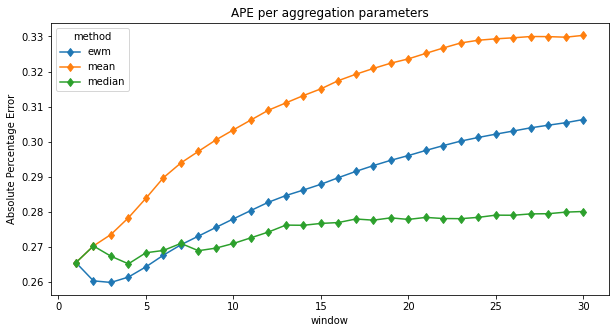

In [21]:
mte_wide = mean_train_errors.reset_index().pivot(
    index="window", columns="method", values=0
)
mte_wide.plot(marker="d", figsize=(10, 5), title="APE per aggregation parameters")
plt.ylabel("Absolute Percentage Error");

In [22]:
train_errors.loc[(slice(None), *agg_params)].round(4)

symbol
AAPL    0.2418
AMZN    0.2445
FB      0.2716
GOOG    0.2516
NFLX    0.2893
dtype: float64

In [23]:
test_errors = {}
for symbol, vol in test.groupby("symbol"):
    preds = rolling_agg(vol, *agg_params)
    test_errors[symbol] = abs_perc_error(preds, vol).mean()
test_errors = pd.Series(test_errors)

In [24]:
print("Error per stock:")
test_errors.round(4)

Error per stock:


AAPL    0.1877
AMZN    0.2331
FB      0.2507
GOOG    0.2382
NFLX    0.2987
dtype: float64

In [25]:
print("Average error:", round(test_errors.mean(), 4))

Average error: 0.2417


## Day of week

Volume tends to be different on certain days of the week.

For example it tends to larger on Fridays due to option contract expiries.

We will try to estimate this effect by calculating mean of ratio of volume or particular day of the week to weekly average volume.

Later we will adjust our preds using Day of the week factors as follows: 

$$ \hat{V}_{DOW} = \hat{V} * \beta_{DoW} $$

Where $\hat{V}$ is prediction based on aggregation from step 1. 

In [26]:
def fit_dow_factors(data, per_symbol=False):
    """Fit day of the week factors.

    Factors are multiplicative i.e. multiply normal volume to adjust.

    Parameters
    ----------
    data : pd.Series or pd.DataFrame
        volume data with date and symbol
    per_symbol : bool, optional
        separate parameters for each symbol, by default False

    Returns
    -------
    pd.Series
        Day of the week factors.
    """    
    # need this if date is in the index
    if data.index.name is not None or len(data.index.names) > 1:
        data = data.reset_index()

    yr_str =  data["date"].dt.year.astype(str)
    week_str =  data["date"].dt.isocalendar().week.astype(str)
    data["week"] =  yr_str + week_str # need this to uniquely identify weeks
    data["week_avg"] = data.groupby(["symbol", "week"])["volume"].transform("mean")
    data["ratio"] = data["volume"] / data["week_avg"]
    data["dow"] = data["date"].dt.dayofweek
    if not per_symbol:
        dow_factors = data.groupby("dow")["ratio"].mean()
    else:
        dow_factors = data.groupby(["symbol", "dow"])["ratio"].mean()
    dow_factors.name = "dow_factor"
    return dow_factors

In [27]:
train

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2020-12-31  AAPL       99116600
            AMZN        2957200
            FB         12900400
            GOOG        1011900
            NFLX        5392300
Name: volume, Length: 5035, dtype: int64

In [28]:
dow_factors = fit_dow_factors(train)

In [29]:
dow_factors.round(3)

dow
0    1.001
1    0.990
2    0.987
3    0.982
4    1.041
Name: dow_factor, dtype: float64

In [30]:
def adjust_preds_dow(preds, dow_factors):
    """Adjust volume predictions using DoW factors.

    Parameters
    ----------
    preds : pd.Series
        Volume preds with date index
    dow_factors : pd.Series
        DoW factors

    Returns
    -------
    pd.Series
        Updated preds
    """    
    reindex_index = preds.index.get_level_values("date").dayofweek
    preds = preds * pd.Series(
        dow_factors.reindex(index=reindex_index).to_numpy(), index=preds.index
    )
    return preds

In [31]:
def predict_agg_dow(vol, agg_params, dow_factors):
    """Predict volumes based on historical volume aggregation and DoW factors.

    Parameters
    ----------
    vol : pd.Series
        Volume data with date index
    agg_params : tuple
        (window, method)
    dow_factors : pd.Series
        DoW factors

    Returns
    -------
    pd.Series
        Volume predictions
    """    
    preds = predict_agg(vol, agg_params)
    preds = adjust_preds_dow(preds, dow_factors)
    return preds

In [32]:
dow_test_errors = {}
for symbol, vol in test.groupby("symbol"):
    preds = predict_agg_dow(vol, agg_params, dow_factors)
    dow_test_errors[symbol] = abs_perc_error(preds, vol).mean()
dow_test_errors = pd.Series(dow_test_errors)

In [33]:
model_comparison = pd.concat([test_errors, dow_test_errors], axis=1).rename(
    columns=["Agg model", "Agg-DoW model"].__getitem__
)
model_comparison.round(4)

,Agg model,Agg-DoW model
AAPL,0.1877,0.1876
AMZN,0.2331,0.2306
FB,0.2507,0.2513
GOOG,0.2382,0.2374
NFLX,0.2987,0.3005


In [34]:
model_comparison.mean().round(4)

Agg model        0.2417
Agg-DoW model    0.2415
dtype: float64

## Autoregressive error component

Finally, we will estimate autoregressive (AR) error component. (It is actually more similar to MA component of ARIMA).

We are assuming that Percentage Error follows autoregressive process AR(1):

$$\hat{\epsilon}_{t} = \beta_{0} + \beta_{1}{\epsilon}_{t-1}$$

Where:

$$\epsilon_{t} = \frac{pred_t - true_t}{true_t} = \frac{pred_t}{true_t} - 1$$

From that follows:

$$ true_t = \frac{pred_t}{1 + \epsilon_t}$$

Therefore, we update our predictions in a following way:

$$\hat{V}_{AR} = \frac{\hat{V}}{1 + \hat{\epsilon}_{t}} = \frac{\hat{V}}{1 +  \beta_{0} + \beta_{1}{\epsilon}_{t-1}}$$

In [35]:
def fit_ar(data, agg_params, dow_factors, per_symbol=False):
    """Fit autoregressive component on top of aggregation and Dow components.

    Parameters
    ----------
    data : pd.Series
        Volume data with date index
    agg_params : tuple
        (window, method)
    dow_factors : pd.Series
        DoW factors
    per_symbol : bool, optional
        fit separate parameters for each symbol, by default False

    Returns
    -------
    pd.Series
        AR parameters
    pd.DataFrame
        Aggregation-Dow errors used for fitting
    statsmodels.regression.linear_model.OLSResults
        OLS fit result
    """    
    ap = agg_params
    dowf = dow_factors

    agg_per_symbol = isinstance(ap, pd.Series)
    dow_per_symbol = len(dowf.index.names) == 2

    agg_dow_errors = []
    for symbol, vol in data.groupby("symbol"):
        if agg_per_symbol:
            ap = agg_params[symbol]
        if dow_per_symbol:
            dowf = dow_factors[symbol]
        preds = predict_agg_dow(vol, ap, dowf)
        agg_dow_errors.append(perc_error(preds, vol).dropna())
    agg_dow_errors = pd.concat(agg_dow_errors).sort_index()
    agg_dow_errors = pd.concat(
        [agg_dow_errors, agg_dow_errors.groupby("symbol").shift(1)], axis=1
    )
    agg_dow_errors.columns = ["e", "e_lag1"]
    agg_dow_errors = agg_dow_errors.dropna()

    if not per_symbol:
        ols_fit_res = sm.OLS(
            agg_dow_errors["e"], sm.add_constant(agg_dow_errors["e_lag1"])
        ).fit()
        ar_params = ols_fit_res.params
    else:
        ols_fit_res = {}
        ar_params = {}
        for symbol, errors in agg_dow_errors.groupby("symbol"):
            ols_fit_res[symbol] = sm.OLS(
                errors["e"], sm.add_constant(errors["e_lag1"])
            ).fit()
            ar_params[symbol] = ols_fit_res[symbol].params
        ar_params = pd.concat(ar_params, names=["symbol"])

    return ar_params, agg_dow_errors, ols_fit_res

In [36]:
train

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2020-12-31  AAPL       99116600
            AMZN        2957200
            FB         12900400
            GOOG        1011900
            NFLX        5392300
Name: volume, Length: 5035, dtype: int64

In [37]:
agg_params

(3, 'ewm')

In [38]:
dow_factors

dow
0    1.000843
1    0.989683
2    0.986959
3    0.982354
4    1.040783
Name: dow_factor, dtype: float64

In [39]:
ar_params, agg_dow_errors, ar_ols_fit = fit_ar(train, agg_params, dow_factors)

In [40]:
ar_params

const     0.064950
e_lag1    0.128816
dtype: float64

In [41]:
agg_dow_errors

e    e_lag1
date       symbol                    
2017-01-09 AAPL   -0.179873 -0.251746
           AMZN    0.581400 -0.208609
           FB      0.079790 -0.281752
           GOOG    0.155868 -0.171092
           NFLX    0.754985 -0.081119
...                     ...       ...
2020-12-31 AAPL    0.065286  0.152037
           AMZN    0.341567  0.419787
           FB      0.123536  0.419443
           GOOG    0.278158 -0.100729
           NFLX   -0.520044  0.729638

[5015 rows x 2 columns]

In [42]:
ar_ols_fit

<AxesSubplot:xlabel='e_lag1', ylabel='e'>

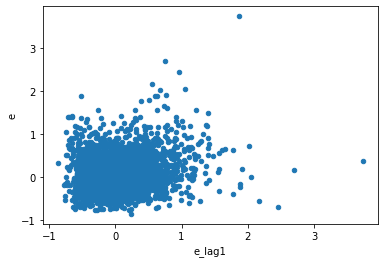

In [43]:
agg_dow_errors.plot.scatter(x="e_lag1", y="e")

In [44]:
ar_ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      e   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     84.58
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           5.30e-20
Time:                        17:09:43   Log-Likelihood:                -1786.1
No. Observations:                5015   AIC:                             3576.
Df Residuals:                    5013   BIC:                             3589.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0650      0.005     13.018      0.000       0.055       0.075
e_lag1         0.1288      0.014      9.197      0.000       0.101       0.156
==============================================================================
Omnibus:                     1227.783   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5796.949
Skew:                           1.105   Prob(JB):                         0.00
Kurtosis:                       7.781   Cond. No.                         2.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
def predict_agg_dow_ar(vol, agg_params, dow_factors, ar_params):
    preds = predict_agg_dow(vol, agg_params, dow_factors)
    err = perc_error(preds, vol)
    pred_errors = ar_params["const"] + ar_params["e_lag1"] * err.shift(1)
    preds = preds / (pred_errors + 1)
    return preds

In [46]:
ar_test_errors = {}
for symbol, vol in test.groupby("symbol"):
    ar_preds = predict_agg_dow_ar(vol, agg_params, dow_factors, ar_params)
    ar_test_errors[symbol] = abs_perc_error(ar_preds, vol).mean()
ar_test_errors = pd.Series(ar_test_errors)

In [47]:
model_comparison = pd.concat(
    [test_errors, dow_test_errors, ar_test_errors], axis=1
).rename(columns=["Agg model", "Agg-DoW model", "Agg-DoW-AR model"].__getitem__)
model_comparison.round(4)

,Agg model,Agg-DoW model,Agg-DoW-AR model
AAPL,0.1877,0.1876,0.1732
AMZN,0.2331,0.2306,0.2126
FB,0.2507,0.2513,0.2360
GOOG,0.2382,0.2374,0.2180
NFLX,0.2987,0.3005,0.2731


In [48]:
model_comparison.mean().round(4)

Agg model           0.2417
Agg-DoW model       0.2415
Agg-DoW-AR model    0.2226
dtype: float64

# Separate model for each stock

This section is part of your labwork/homework.

Repeate previous sections, but this time fit parameters separately for each symbol.

*Hint: Use per_symbol=True*

## Optimal aggregation

In [49]:
train

date        symbol
2017-01-03  AAPL      115127600
            AMZN        3521100
            FB         20663900
            GOOG        1657300
            NFLX        9437900
                        ...    
2020-12-31  AAPL       99116600
            AMZN        2957200
            FB         12900400
            GOOG        1011900
            NFLX        5392300
Name: volume, Length: 5035, dtype: int64

In [50]:
print(params_grid[:5])
print(params_grid[-5:])

[(1, 'mean'), (1, 'median'), (1, 'ewm'), (2, 'mean'), (2, 'median')]
[(29, 'median'), (29, 'ewm'), (30, 'mean'), (30, 'median'), (30, 'ewm')]


In [51]:
agg_params2, train_errors2 = find_optimal_agg(train, params_grid, per_symbol=True)

In [52]:
agg_params2

symbol
AAPL    (4, median)
AMZN       (2, ewm)
FB         (2, ewm)
GOOG    (3, median)
NFLX       (3, ewm)
Name: agg_params, dtype: object

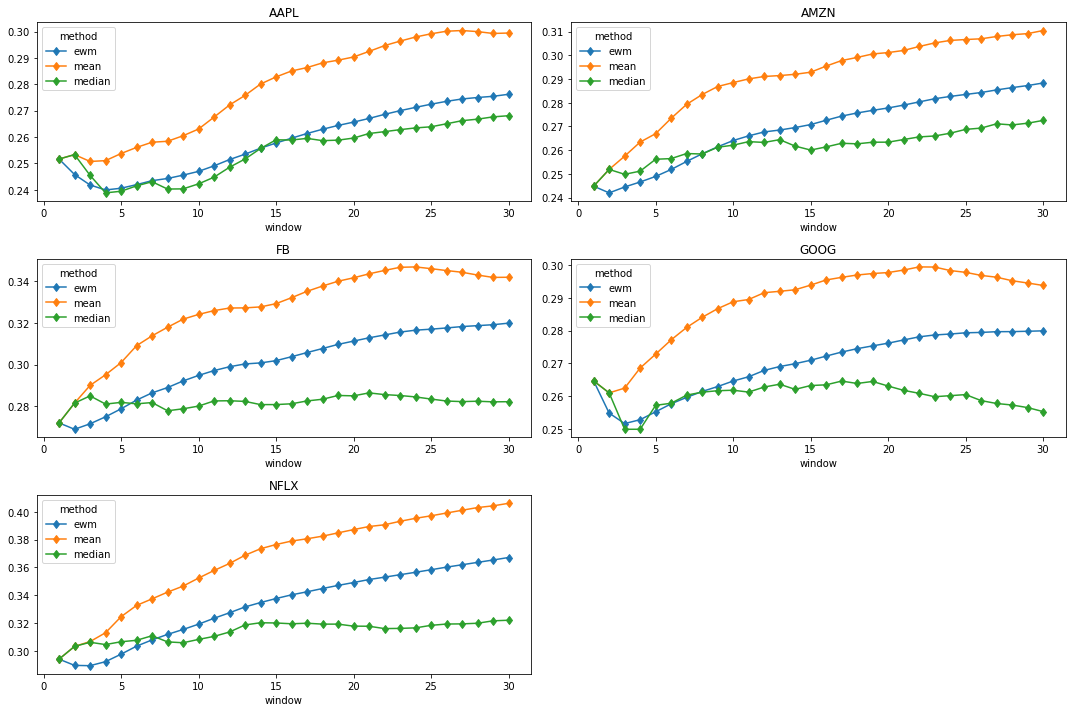

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for (symbol, df), ax in zip(train_errors.groupby("symbol"), axes.reshape(-1)):
    df = df.reset_index().pivot(index="window", columns="method", values=0)
    df.plot(ax=ax, marker="d", title=symbol)
axes.reshape(-1)[-1].set_axis_off()
plt.tight_layout()

In [54]:
test_errors2 = {}
for symbol, vol in test.groupby("symbol"):
    preds = predict_agg(vol, agg_params2[symbol])
    test_errors2[symbol] = abs_perc_error(preds, vol).mean()
test_errors2 = pd.Series(test_errors2)

In [55]:
print("Error per stock:")
test_errors2.round(4)

Error per stock:


AAPL    0.2074
AMZN    0.2319
FB      0.2590
GOOG    0.2447
NFLX    0.2987
dtype: float64

In [56]:
print("Average error:", round(test_errors2.mean(), 4))

Average error: 0.2484


In [57]:
model_comparison = pd.concat(
    [test_errors, test_errors2], axis=1
).rename(columns=["common", "separate"].__getitem__)
model_comparison.round(4)

,common,separate
AAPL,0.1877,0.2074
AMZN,0.2331,0.2319
FB,0.2507,0.2590
GOOG,0.2382,0.2447
NFLX,0.2987,0.2987


In [58]:
model_comparison.mean().round(4)

common      0.2417
separate    0.2484
dtype: float64

## Day of week

## Autoregressive error component

# Homework 

## Q1.

Repeat estimation of a model but this time estimate parameters **separately** for each symbol (stock). "Optimal aggregation" - part has already been done. For each component compare **test error** of model with common parameters vs. model with separate parameters. Which model is better in your opinion? Why?

## Q2

1. What are potential flaws of the modelling approach presented in this notebook?
2. How could the model be improved?

## Q3 
Try to improve the model and compare it with approach presented above. It can be either modification of the model above **OR** completely different approach i.e. ARIMA, Random Forest, Boosted Trees like XGBoost, Neural Net. Just keep it simple and make it work without GPU.